### Задача:
По имеющимся разделенным на 2 класса твитам (положительные твиты / негативные (оскорбительные) твиты) обучить нейросеть для дальнейшего детектирования оскорбительного контента.
Датасет доступен по ссылке:
https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

##### 1. Установка и импорт библиотек

In [1]:
!pip install stop-words nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from string import punctuation
import warnings
warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_auc_score
from torchsummary import summary

nltk.download('wordnet')
nltk.download('punkt')


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\lazar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'torchsummary'

##### 2. Выбор среды для обучения:

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_properties(device))
else:
    print('using CPU')
    device = torch.device('cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


##### 3. Импорт датасета для обучения

In [3]:
path_to_train_data = r'./dataset.csv'
df = pd.read_csv(path_to_train_data, sep=',', encoding='utf-8', index_col='id')
df_x, df_y = df['tweet'].copy(), df['label'].copy()
df.head(3)

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty


In [ ]:
# Наблюдается большой дисбаланс классов. В связи с малым количеством объектов класса 1, для валидации оставим небольшую часть данных (15%)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, shuffle=True, test_size=0.15, stratify=df_y, random_state=1)
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

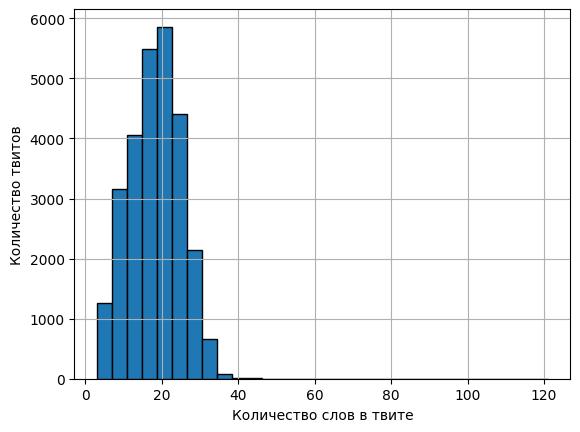

In [ ]:
# Проанализируем количество слов в твитах, чтобы выявить оптимальную длину кодировки сообщений
temp = pd.DataFrame({'source':x_train})
temp.loc[:, 'lenght'] = temp['source'].apply(lambda item: len(list(word_tokenize(item))))
temp['lenght'].hist(bins=30, ec='black')
plt.xlabel('Количество слов в твите')
plt.ylabel('Количество твитов')
plt.show()

In [ ]:
print(f"Максимальное количество слов в твите: {temp['lenght'].max()}")
print(f"Количество твитов с количеством слов > 40: {temp[temp['lenght'] >= 40].shape[0]}")

Максимальное количество слов в твите: 121
Количество твитов с количеством слов > 40: 19


###### Вывод:
Максимальное количество слов в сообщениях - 121, что сильно нагружает ПК. Т.к. количество твитов, превышающих 40 символов, всего 19, то установлю макисмальное количество символов твита равным 40. Оставшиеся 19 твитов из обработки не убираю - для них твит будет кодироваться символами, соответствующими первым 40 словам.
Таким образом, каждый твит будет закодирован последовательностью из 40 элементов.

In [ ]:
stopwords = get_stop_words('en')
stopwords.append("'s")
symbols = list(set(punctuation))
lemmatizer = WordNetLemmatizer()

##### 4. Создание класса датасета

Предобработка данных происходит во время инициализации датасета. В предобработку входит:
1. Генерация общего словаря пар слово-номер для дальнейшей кодировки предложений из n самых популярных символов.
2. Токенизация предложений.
3. Удаление стоп-слов (слов без особой смысловой нагрузки), знаков пунктуации.
4. Лемматизация слов-токенов.
5. Кодировка предложений последовательностью номеров с заменой "незначащих" слов нулями (их нет в словаре)

In [ ]:
class TwitDataset(Dataset):
    def __init__(self, x:pd.Series, y:pd.Series, device, punctuation_symbols, stop_words, lemmatizer, vocabulary = None, max_vocabulary_size=2500, max_tweet_size = 40):
        x = x.apply(lambda message: message.lower())
        self.device = device
        self.punctuation_symbols = punctuation_symbols
        self.stop_words = stop_words
        self.lemmatizer = lemmatizer
        self.max_twit_size = max_tweet_size

        if vocabulary == None:
            self.vocabulary = self.__set_dictionary(x, max_size=max_vocabulary_size)
        else:
            self.vocabulary = vocabulary

        self.x = pd.DataFrame({'source': x.tolist()})
        self.x.loc[:, 'sequence'] = self.x['source'].apply(lambda item: self.__parse_text_to_sequence(item))
        self.y = y

    # parse message to limmatized list without using vocabulary
    def parse_text_to_lemmatized_dict(self, text:str):
        # make tokens from words
        tokens = word_tokenize(text)

        # drop unuseful words: punctuation and etc.
        tokens_filtered = [el for el in tokens if el.isalnum()]
        df = pd.DataFrame({'words':tokens_filtered})

        # drop all punctuation symbols
        df = df[~df['words'].isin(self.punctuation_symbols)]

        # drop all stopwords
        df = df[~df['words'].isin(self.stop_words)]

        # make lemmatization
        df.loc[:, 'words_lemmatized'] = df['words'].apply(lambda x: self.lemmatizer.lemmatize(x))
        tokens_filtered = df['words_lemmatized'].tolist()
        return tokens_filtered


    # develop vocabulary for lemmatized_word - key_number relationships
    def __set_dictionary(self, messages:pd.Series, max_size=2500):
        # parse twits to one big common twit-message
        all_messages = ''
        for el in messages.tolist():
            all_messages = f'{all_messages} {el}'

        # create lemmatized, stop-words and punctuations-dropped massive
        tokens_filtered = self.parse_text_to_lemmatized_dict(all_messages)

        # create frequancy-orientated massive from tokens for most popular words
        tokens_filtered = FreqDist(tokens_filtered)
        tokens_filtered_top = [pair[0] for pair in tokens_filtered.most_common(max_size-1)]

        # create common vocabulary for all messages in dataset (x_train+x_test)
        vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
        return vocabulary


    # parse message to sequence using vocabulary
    def __parse_text_to_sequence(self, message:str):
        # create lemmatized, stop-words and punctuations-dropped massive
        tokens_filtered = self.parse_text_to_lemmatized_dict(message)

        # create sequence using global vocabulary
        parsed_text = [self.vocabulary[word] if word in self.vocabulary.keys() else 0 for word in tokens_filtered]

        # fill places for unexisted words with zeroes
        while len(parsed_text) < self.max_twit_size:
            parsed_text.append(0)
        return parsed_text[:self.max_twit_size]


    # return sample`s count
    def __len__(self):
        return self.x.shape[0]


    # return sample by index
    def __getitem__(self, index):
        x = self.x['sequence'].iloc[index]
        y = self.y.iloc[index]
        return torch.IntTensor(x).to(self.device), torch.IntTensor([y]).to(self.device)


train_dataset = TwitDataset(x_train, y_train, device, symbols, stopwords, lemmatizer)
test_dataset = TwitDataset(x_test, y_test, device, symbols, stopwords, lemmatizer, vocabulary=train_dataset.vocabulary)

In [ ]:
# Демонстрация получемых данных из Датасета:
idx = 500
print(test_dataset.__getitem__(idx))
print('-----------')
print(test_dataset.x.iloc[idx])

(tensor([  1, 127,  92, 254, 542,   4,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       device='cuda:0', dtype=torch.int32), tensor([0], device='cuda:0', dtype=torch.int32))
-----------
source       @user old guy off for some sleep  be #safe &a...
sequence    [1, 127, 92, 254, 542, 4, 0, 0, 0, 0, 0, 0, 0,...
Name: 500, dtype: object


##### 5. Создание класса DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)

##### 6. Создание класса нейросети

In [ ]:
class LSTM_Net(nn.Module):
    def __init__(self, vocab_size=2500, embedding_dim=256, hidden_dim=32, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3)
        self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        out_pack, (hn, ct) = self.lstm(x)
        x = self.linear(hn[-1])
        x = F.sigmoid(x)
        return x

##### 7. Обучение нейросети

In [ ]:
model = LSTM_Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

model = model.to(device)
model.train()
th = 0.5

epochs = 500

for epoch in range(epochs + 1):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())

    if epoch % 100 == 0:
        # выводим статистику о процессе обучения
        model.eval()

        print(f'Epoch [{epoch}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Train Loss: {loss:.6f}.')

        # выводим статистику на тестовых данных
        for j, data in enumerate(test_loader):
            test_labels = data[1]
            test_outputs = model(data[0])

            # подсчет метрики на тесте
            test_labels =  test_labels.cpu().detach().numpy()
            test_outputs = test_outputs.cpu().detach().numpy()
            test_outputs[test_outputs<th] = 0
            test_outputs[test_outputs>=th] = 1
            pr, rc, auc = precision_score(test_labels, test_outputs), recall_score(test_labels, test_outputs), roc_auc_score(test_labels, test_outputs)
            print(f"Test precision: {pr:.3f}, Test recall: {rc:.3f}, Test Roc-Auc: {auc:.3f}\n")
        model.train()

print('Training is finished!')

Epoch [0/500]. Step [425/425]. Train Loss: 0.321009.
Test precision: 0.000, Test recall: 0.000, Test Roc-Auc: 0.500

Epoch [100/500]. Step [425/425]. Train Loss: 0.070284.
Test precision: 0.656, Test recall: 0.613, Test Roc-Auc: 0.794

Epoch [200/500]. Step [425/425]. Train Loss: 0.003779.
Test precision: 0.708, Test recall: 0.598, Test Roc-Auc: 0.790

Epoch [300/500]. Step [425/425]. Train Loss: 0.006653.
Test precision: 0.681, Test recall: 0.616, Test Roc-Auc: 0.797

Epoch [400/500]. Step [425/425]. Train Loss: 0.001342.
Test precision: 0.700, Test recall: 0.604, Test Roc-Auc: 0.792

Epoch [500/500]. Step [425/425]. Train Loss: 0.000168.
Test precision: 0.707, Test recall: 0.604, Test Roc-Auc: 0.793

Training is finished!


##### 8. Промежуточный вывод:
Анлизируя тестовые метрики, видно, что модель после 500 эпохи начинает "упираться" в потолок. Можно попробовать изменить архитектуру сети / гиперпараметры с целью улучшения качества модели:

In [ ]:
class GRU_Net(nn.Module):
    def __init__(self, vocab_size=2500, embedding_dim=256, hidden_dim=32, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers=3)
        self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        out_pack, hn = self.gru(x)
        x = self.linear(hn[-1])
        x = F.sigmoid(x)
        return x

In [ ]:
model = GRU_Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

model = model.to(device)
model.train()
th = 0.5

epochs = 500

for epoch in range(epochs + 1):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())

    if epoch % 100 == 0:
        # выводим статистику о процессе обучения
        model.eval()

        print(f'Epoch [{epoch}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Train Loss: {loss:.6f}.')

        # выводим статистику на тестовых данных
        for j, data in enumerate(test_loader):
            test_labels = data[1]
            test_outputs = model(data[0])

            # подсчет метрики на тесте
            test_labels =  test_labels.cpu().detach().numpy()
            test_outputs = test_outputs.cpu().detach().numpy()
            test_outputs[test_outputs<th] = 0
            test_outputs[test_outputs>=th] = 1
            pr, rc, auc = precision_score(test_labels, test_outputs), recall_score(test_labels, test_outputs), roc_auc_score(test_labels, test_outputs)
            print(f"Test precision: {pr:.3f}, Test recall: {rc:.3f}, Test Roc-Auc: {auc:.3f}\n")

        model.train()

print('Training is finished!')

Epoch [0/500]. Step [425/425]. Train Loss: 0.321378.
Test precision: 0.000, Test recall: 0.000, Test Roc-Auc: 0.500

Epoch [100/500]. Step [425/425]. Train Loss: 0.096359.
Test precision: 0.712, Test recall: 0.619, Test Roc-Auc: 0.800

Epoch [200/500]. Step [425/425]. Train Loss: 0.038113.
Test precision: 0.680, Test recall: 0.652, Test Roc-Auc: 0.814

Epoch [300/500]. Step [425/425]. Train Loss: 0.002538.
Test precision: 0.718, Test recall: 0.628, Test Roc-Auc: 0.805

Epoch [400/500]. Step [425/425]. Train Loss: 0.000502.
Test precision: 0.726, Test recall: 0.622, Test Roc-Auc: 0.802

Epoch [500/500]. Step [425/425]. Train Loss: 0.001612.
Test precision: 0.746, Test recall: 0.622, Test Roc-Auc: 0.803

Training is finished!


##### 9. Промежуточный вывод:
Анлизируя тестовые метрики, видно, что модель после 500 эпохи начинает "упираться" в потолок. Однако архитектура GRU показала себя лучше, чем LSTM

##### 10. Вывод:
Как видно, в процессе обучение продолжает улучшаться precision 1го класса при незначительных изменениях recall и roc-auc. Безлайн решения - примерно 7%, качество полученного решения - примерно 60% (f1-мера), что лучше почти в 10 раз.

Примечательно, что и LSTM, и GRU показывают приблизительно одинаковое качество. Однако GRU в силу своей архитектуры обучается быстрее - в дальнейшем следовало бы отдать предпочтение именно GRU.

##### 11. Потенциальные работы по улучшению качества модели:
1. Продолжение обучения текущей сети.
2. Подбор порога отсечки класса 1 и 0 (threshold)
3. Изменение количества слов в словаре
4. Изменение количества слов в предложении
4. В данном прримере "незначащие" слова были заменены нулями. Можно попробовать вместо это очистить предложение от "незначащих слов".
5. Изменение архитектуры сети
6. Изменение оптимизатора